In [1]:
import torch
from pathlib import Path
import os
import random
from PIL import Image
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

e:\annaconda\envs\pytorch_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
image_data = Path("D:\CSM character classifier\data")
labels = ['Aki', "Denji", "Makima", "Power"]
for path, dirnames, filenames in os.walk(image_data):
    print(f"There are {len(dirnames)} files, {len(filenames)} images a in {path}")

There are 2 files, 0 images a in D:\CSM character classifier\data
There are 4 files, 0 images a in D:\CSM character classifier\data\Test data
There are 0 files, 84 images a in D:\CSM character classifier\data\Test data\Aki
There are 0 files, 56 images a in D:\CSM character classifier\data\Test data\Denji
There are 0 files, 95 images a in D:\CSM character classifier\data\Test data\Makima
There are 0 files, 100 images a in D:\CSM character classifier\data\Test data\Power
There are 4 files, 0 images a in D:\CSM character classifier\data\Train data
There are 0 files, 413 images a in D:\CSM character classifier\data\Train data\AKI
There are 0 files, 499 images a in D:\CSM character classifier\data\Train data\Denji
There are 0 files, 500 images a in D:\CSM character classifier\data\Train data\Makima
There are 0 files, 498 images a in D:\CSM character classifier\data\Train data\Power


In [3]:
train_path = image_data/"Train data"
test_path = image_data/'Test data'

In [4]:
image_path_list = []
image_path_list.extend(list(image_data.rglob("*.jpg")))
image_path_list.extend(list(image_data.rglob("*.png")))

len(image_path_list)

2244

image path:  D:\CSM character classifier\data\Train data\Power\478.jpg
image width:  992
image height:  1403


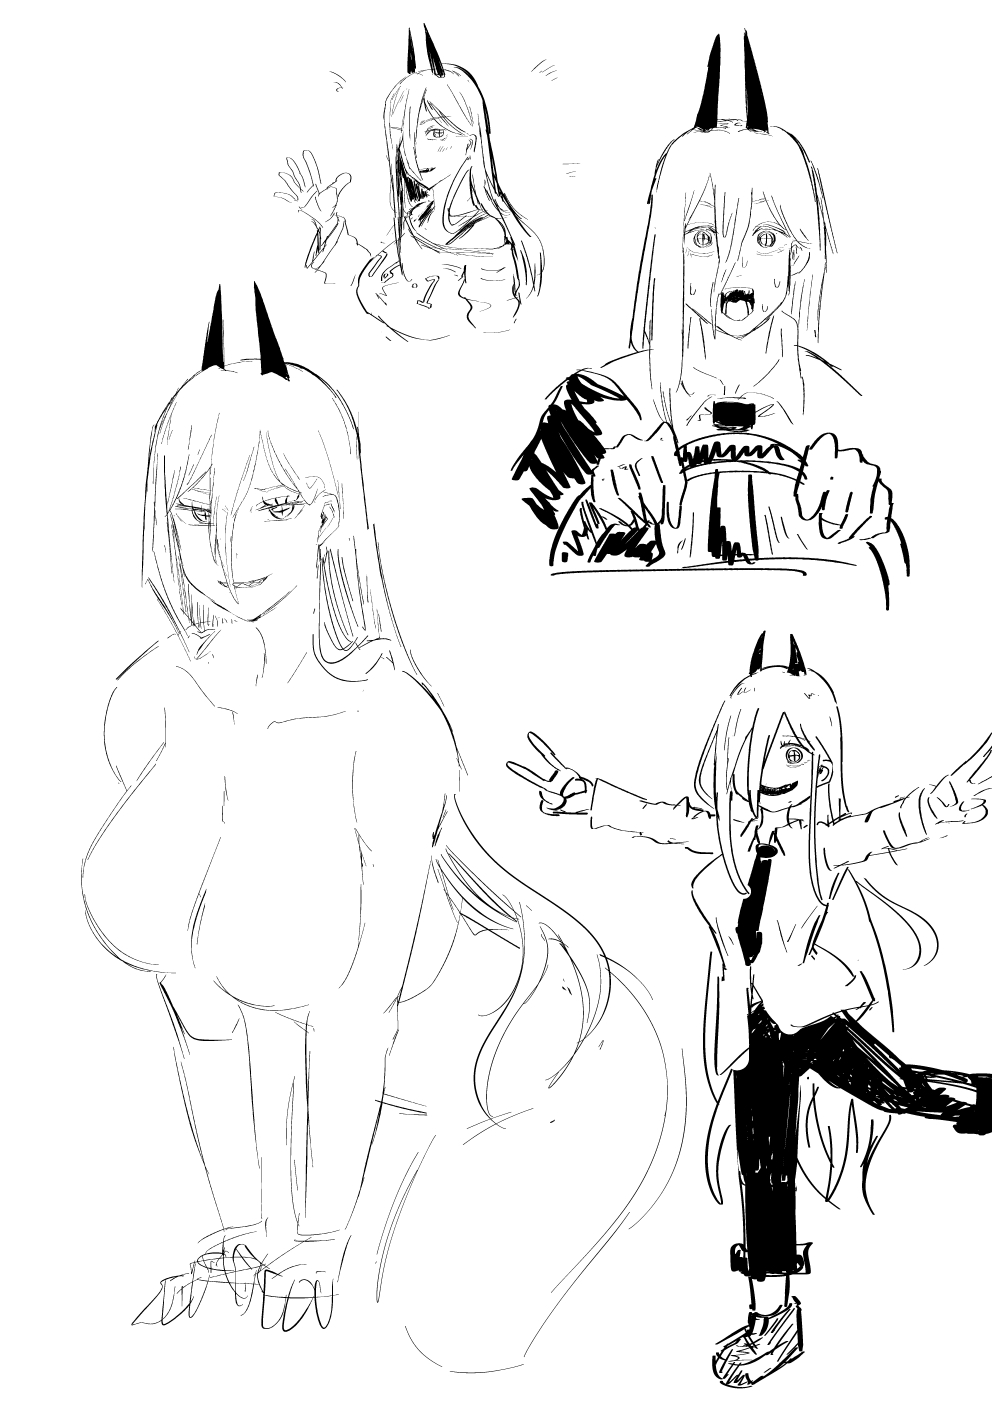

In [5]:
random_image_path = random.choice(image_path_list)
img_rand = Image.open(random_image_path)
print("image path: ", random_image_path)
print("image width: ", img_rand.width)
print("image height: ", img_rand.height)
img_rand

In [6]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((128, 128), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),                           # Keep angle small
    #transforms.ColorJitter(0.1, 0.1, 0.1, 0.05),              # Slight jitter
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3) 
])

train_dataset = ImageFolder(train_path, transform=train_transform)
test_dataset = ImageFolder(test_path, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
img, l = next(iter(train_loader))

imgs =img[0].permute(1, 2, 0).numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9764706].


Power


(np.float64(-0.5), np.float64(127.5), np.float64(127.5), np.float64(-0.5))

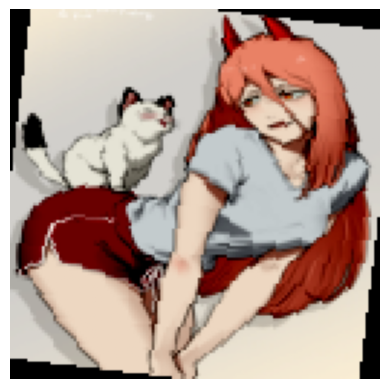

In [8]:
print(labels[l[0]])
plt.imshow(imgs)
plt.axis(False)

In [9]:
class ConvolutionalNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1),
            nn.ReLU()
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1),
            nn.ReLU()
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, stride=1),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2)
        )
        self.block5 = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(in_features=8410, out_features=4)
        )
    def forward(self, x):
        return self.block5(self.block4(self.block3(self.block2(self.block1(x)))))

model0 = ConvolutionalNN().to(device=device)
optimizer = torch.optim.Adam(model0.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

In [10]:
def trainingloop(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader,
                  loss_func: torch.nn.modules.loss._Loss, optimize: torch.optim.Optimizer, device: torch.device= device):
    from sklearn.metrics import accuracy_score
    model.train()
    trainloss = 0
    accuracy = 0
    for (x, y) in (dataloader):
        x, y = x.to(device), y.to(device)
        ypred = model(x)
        preds = ypred.argmax(dim=1).cpu()
        loss = loss_func(ypred, y)
        trainacc = accuracy_score(y_true=y.cpu(), y_pred=preds)
        trainloss += loss.item()
        accuracy += trainacc
        
        optimize.zero_grad()

        loss.backward()

        optimize.step()
    trainloss /= len(dataloader)
    accuracy /= len(dataloader)
    print(f"Trainning loss= {trainloss} | Train Accuracy = {accuracy}")
    return trainloss, accuracy


In [11]:
def testingloop(model: torch.nn.Module, dataloader: torch.utils.data.dataloader, loss_func: nn.modules.loss._Loss, device: torch.device= device):
    model.eval()

    testloss = 0
    accuracy = 0
    from sklearn.metrics import accuracy_score
    with torch.inference_mode():
        for(x, y) in dataloader:
            x, y = x.to(device), y.to(device)
            ypred = model(x)
            preds = ypred.argmax(dim=1).cpu()
            loss = loss_func(ypred, y)
            testacc = accuracy_score(y.cpu(), preds)
            testloss += loss.item()
            accuracy += testacc
        testloss /= len(dataloader)
        accuracy /= len(dataloader)
        print(f"Test loss= {testloss} | Test Accuracy = {accuracy}")
        return testloss, accuracy

In [12]:
epochs = 50

trainloss, testloss, trainacc, testacc = [], [], [], []
for epoch in tqdm(range(epochs)):

    print(f"______________________________________\nEpoch: {epoch+1}\n______________________________________")
    a, b = trainingloop(model0, train_loader, loss_fn,optimizer, device)
    c, d = testingloop(model0, test_loader, loss_fn, device)
    trainloss.append(a)
    trainacc.append(b)
    testloss.append(c)
    testacc.append(d)



  0%|          | 0/50 [00:00<?, ?it/s]

______________________________________
Epoch: 1
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 1.3713020543257395 | Train Accuracy = 0.29038825757575754


  2%|▏         | 1/50 [02:39<2:09:58, 159.16s/it]

Test loss= 1.2741615122014827 | Test Accuracy = 0.425
______________________________________
Epoch: 2
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 1.1511567741632462 | Train Accuracy = 0.4999526515151515


  4%|▍         | 2/50 [04:58<1:57:46, 147.21s/it]

Test loss= 1.2495005239139905 | Test Accuracy = 0.49450757575757576
______________________________________
Epoch: 3
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.9901355832815171 | Train Accuracy = 0.5929450757575758


  6%|▌         | 3/50 [08:24<2:16:41, 174.51s/it]

Test loss= 1.0455666238611394 | Test Accuracy = 0.6020833333333333
______________________________________
Epoch: 4
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.9191703776518504 | Train Accuracy = 0.6332859848484849


  8%|▊         | 4/50 [11:54<2:24:14, 188.14s/it]

Test loss= 1.064413084225221 | Test Accuracy = 0.6113636363636363
______________________________________
Epoch: 5
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.8763544072707494 | Train Accuracy = 0.6608901515151515


 10%|█         | 5/50 [15:23<2:26:46, 195.71s/it]

Test loss= 1.0802921761165967 | Test Accuracy = 0.5935606060606061
______________________________________
Epoch: 6
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.851454837123553 | Train Accuracy = 0.6744318181818182


 12%|█▏        | 6/50 [18:51<2:26:37, 199.94s/it]

Test loss= 0.993345087224787 | Test Accuracy = 0.640530303030303
______________________________________
Epoch: 7
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.8431331038475036 | Train Accuracy = 0.6719223484848484


 14%|█▍        | 7/50 [22:19<2:25:14, 202.66s/it]

Test loss= 1.0742266042666002 | Test Accuracy = 0.609280303030303
______________________________________
Epoch: 8
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.8387653693556786 | Train Accuracy = 0.6812026515151516


 16%|█▌        | 8/50 [25:25<2:18:13, 197.45s/it]

Test loss= 1.0329590927470813 | Test Accuracy = 0.6077651515151515
______________________________________
Epoch: 9
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.8048757195472718 | Train Accuracy = 0.6898200757575758


 18%|█▊        | 9/50 [28:51<2:16:41, 200.04s/it]

Test loss= 1.0632542263377796 | Test Accuracy = 0.6231060606060607
______________________________________
Epoch: 10
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.7941246996323268 | Train Accuracy = 0.6908143939393939


 20%|██        | 10/50 [32:16<2:14:20, 201.52s/it]

Test loss= 1.118738504973325 | Test Accuracy = 0.5647727272727273
______________________________________
Epoch: 11
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.7849734177192053 | Train Accuracy = 0.7074810606060605


 22%|██▏       | 11/50 [35:40<2:11:33, 202.39s/it]

Test loss= 1.091085116971623 | Test Accuracy = 0.6227272727272727
______________________________________
Epoch: 12
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.7813865770896276 | Train Accuracy = 0.6957386363636363


 24%|██▍       | 12/50 [39:06<2:08:47, 203.35s/it]

Test loss= 0.9961410760879517 | Test Accuracy = 0.6251893939393939
______________________________________
Epoch: 13
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.7670766025781631 | Train Accuracy = 0.7056344696969696


 26%|██▌       | 13/50 [42:28<2:05:07, 202.91s/it]

Test loss= 1.0462008010257373 | Test Accuracy = 0.6162878787878788
______________________________________
Epoch: 14
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.7529103964567184 | Train Accuracy = 0.7132102272727272


 28%|██▊       | 14/50 [45:15<1:55:13, 192.05s/it]

Test loss= 0.9713682315566323 | Test Accuracy = 0.6450757575757575
______________________________________
Epoch: 15
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.734355890750885 | Train Accuracy = 0.7147727272727272


 30%|███       | 15/50 [47:17<1:39:47, 171.06s/it]

Test loss= 1.0514335253021934 | Test Accuracy = 0.596780303030303
______________________________________
Epoch: 16
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.7216656799117724 | Train Accuracy = 0.7344223484848484


 32%|███▏      | 16/50 [49:21<1:28:52, 156.84s/it]

Test loss= 1.0286398502913388 | Test Accuracy = 0.6284090909090909
______________________________________
Epoch: 17
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.7105133990446727 | Train Accuracy = 0.7259469696969697


 34%|███▍      | 17/50 [51:25<1:20:50, 146.97s/it]

Test loss= 1.1122832731767134 | Test Accuracy = 0.6020833333333333
______________________________________
Epoch: 18
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.7320919543504715 | Train Accuracy = 0.7184185606060606


 36%|███▌      | 18/50 [54:15<1:22:05, 153.92s/it]

Test loss= 1.0436332686380907 | Test Accuracy = 0.6348484848484849
______________________________________
Epoch: 19
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.7184919814268748 | Train Accuracy = 0.714157196969697


 38%|███▊      | 19/50 [57:27<1:25:27, 165.40s/it]

Test loss= 0.9891571023247459 | Test Accuracy = 0.6397727272727273
______________________________________
Epoch: 20
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.6936054433385531 | Train Accuracy = 0.737594696969697


 40%|████      | 20/50 [1:00:55<1:29:02, 178.07s/it]

Test loss= 1.0321504473686218 | Test Accuracy = 0.6482954545454546
______________________________________
Epoch: 21
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.6751162980993589 | Train Accuracy = 0.746969696969697


 42%|████▏     | 21/50 [1:04:27<1:31:04, 188.42s/it]

Test loss= 0.9808044487779791 | Test Accuracy = 0.6625
______________________________________
Epoch: 22
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.6726511880755425 | Train Accuracy = 0.7352746212121212


 44%|████▍     | 22/50 [1:08:05<1:32:00, 197.15s/it]

Test loss= 1.0200541886416348 | Test Accuracy = 0.6397727272727273
______________________________________
Epoch: 23
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.6573018332322439 | Train Accuracy = 0.7496212121212121


 46%|████▌     | 23/50 [1:11:44<1:31:38, 203.64s/it]

Test loss= 1.1110592701218345 | Test Accuracy = 0.5996212121212121
______________________________________
Epoch: 24
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.6569796532392502 | Train Accuracy = 0.7431344696969696


 48%|████▊     | 24/50 [1:15:21<1:30:02, 207.78s/it]

Test loss= 1.0621474168517373 | Test Accuracy = 0.6547348484848485
______________________________________
Epoch: 25
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.6549489766359329 | Train Accuracy = 0.7482954545454545


 50%|█████     | 25/50 [1:18:55<1:27:19, 209.59s/it]

Test loss= 1.0222999507730657 | Test Accuracy = 0.6551136363636364
______________________________________
Epoch: 26
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.6431552027662595 | Train Accuracy = 0.7481060606060606


 52%|█████▏    | 26/50 [1:22:33<1:24:48, 212.02s/it]

Test loss= 1.0456321998076006 | Test Accuracy = 0.6337121212121212
______________________________________
Epoch: 27
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.6560608093937238 | Train Accuracy = 0.7556344696969697


 54%|█████▍    | 27/50 [1:26:10<1:21:56, 213.78s/it]

Test loss= 1.0683289657939563 | Test Accuracy = 0.6053030303030303
______________________________________
Epoch: 28
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.6243444815278053 | Train Accuracy = 0.7668087121212122


 56%|█████▌    | 28/50 [1:29:48<1:18:48, 214.94s/it]

Test loss= 1.0116306001489812 | Test Accuracy = 0.6308712121212121
______________________________________
Epoch: 29
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.6366826782623927 | Train Accuracy = 0.7581439393939394


 58%|█████▊    | 29/50 [1:33:22<1:15:04, 214.52s/it]

Test loss= 1.0520321889357134 | Test Accuracy = 0.6621212121212121
______________________________________
Epoch: 30
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.6195577591657638 | Train Accuracy = 0.7710227272727272


 60%|██████    | 30/50 [1:36:58<1:11:41, 215.07s/it]

Test loss= 1.0589387037537314 | Test Accuracy = 0.659280303030303
______________________________________
Epoch: 31
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.6129228820403417 | Train Accuracy = 0.7728219696969697


 62%|██████▏   | 31/50 [1:40:36<1:08:23, 215.98s/it]

Test loss= 1.0521450476212935 | Test Accuracy = 0.6308712121212121
______________________________________
Epoch: 32
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.6035184582074483 | Train Accuracy = 0.778219696969697


 64%|██████▍   | 32/50 [1:44:11<1:04:44, 215.78s/it]

Test loss= 1.186921859329397 | Test Accuracy = 0.637689393939394
______________________________________
Epoch: 33
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.5925065671404203 | Train Accuracy = 0.7714962121212121


 66%|██████▌   | 33/50 [1:47:46<1:01:03, 215.48s/it]

Test loss= 1.161384566263719 | Test Accuracy = 0.6490530303030303
______________________________________
Epoch: 34
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.6029172013203303 | Train Accuracy = 0.7652462121212121


 68%|██████▊   | 34/50 [1:51:21<57:26, 215.42s/it]  

Test loss= 1.221120235594836 | Test Accuracy = 0.6369318181818181
______________________________________
Epoch: 35
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.5998366311192512 | Train Accuracy = 0.7810606060606061


 70%|███████   | 35/50 [1:54:42<52:42, 210.84s/it]

Test loss= 1.1812575513666326 | Test Accuracy = 0.6179924242424243
______________________________________
Epoch: 36
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.5801398868362109 | Train Accuracy = 0.7793087121212121


 72%|███████▏  | 36/50 [1:56:43<42:53, 183.85s/it]

Test loss= 1.1070731986652722 | Test Accuracy = 0.6564393939393939
______________________________________
Epoch: 37
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.5550517871975899 | Train Accuracy = 0.7871212121212121


 74%|███████▍  | 37/50 [1:58:40<35:31, 163.99s/it]

Test loss= 1.236402603712949 | Test Accuracy = 0.6109848484848485
______________________________________
Epoch: 38
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.5831925849119822 | Train Accuracy = 0.7834753787878788


 76%|███████▌  | 38/50 [2:00:46<30:30, 152.50s/it]

Test loss= 1.1365660293535753 | Test Accuracy = 0.6409090909090909
______________________________________
Epoch: 39
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.5636433814962705 | Train Accuracy = 0.787594696969697


 78%|███████▊  | 39/50 [2:02:52<26:29, 144.54s/it]

Test loss= 1.2177898558703335 | Test Accuracy = 0.6547348484848485
______________________________________
Epoch: 40
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.5711838493744532 | Train Accuracy = 0.7881155303030304


 80%|████████  | 40/50 [2:04:58<23:10, 139.04s/it]

Test loss= 1.188383243300698 | Test Accuracy = 0.6454545454545454
______________________________________
Epoch: 41
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.5813232938448588 | Train Accuracy = 0.7765151515151516


 82%|████████▏ | 41/50 [2:07:04<20:15, 135.11s/it]

Test loss= 1.2037342515858738 | Test Accuracy = 0.6454545454545454
______________________________________
Epoch: 42
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.5598693574468295 | Train Accuracy = 0.786032196969697


 84%|████████▍ | 42/50 [2:09:11<17:41, 132.69s/it]

Test loss= 1.2079898498275063 | Test Accuracy = 0.6401515151515151
______________________________________
Epoch: 43
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.5174167742331822 | Train Accuracy = 0.7992897727272728


 86%|████████▌ | 43/50 [2:11:18<15:16, 130.89s/it]

Test loss= 1.2128151004964656 | Test Accuracy = 0.6337121212121212
______________________________________
Epoch: 44
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.5502076551318169 | Train Accuracy = 0.7896306818181817


 88%|████████▊ | 44/50 [2:13:24<12:57, 129.62s/it]

Test loss= 1.1643591360612349 | Test Accuracy = 0.6528409090909091
______________________________________
Epoch: 45
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.5139287645618121 | Train Accuracy = 0.8039772727272728


 90%|█████████ | 45/50 [2:15:30<10:42, 128.53s/it]

Test loss= 1.1256908638910814 | Test Accuracy = 0.6596590909090909
______________________________________
Epoch: 46
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.5297201921542486 | Train Accuracy = 0.806344696969697


 92%|█████████▏| 46/50 [2:17:37<08:31, 127.89s/it]

Test loss= 1.147781103849411 | Test Accuracy = 0.6518939393939394
______________________________________
Epoch: 47
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.5086840366323789 | Train Accuracy = 0.8107954545454545


 94%|█████████▍| 47/50 [2:19:43<06:22, 127.52s/it]

Test loss= 1.0494144613092595 | Test Accuracy = 0.6852272727272727
______________________________________
Epoch: 48
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.5181835706035296 | Train Accuracy = 0.7982481060606061


 96%|█████████▌| 48/50 [2:21:50<04:14, 127.22s/it]

Test loss= 1.1359975744377484 | Test Accuracy = 0.6308712121212121
______________________________________
Epoch: 49
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.5247479098538558 | Train Accuracy = 0.8001420454545455


 98%|█████████▊| 49/50 [2:23:57<02:07, 127.09s/it]

Test loss= 1.1925145496021619 | Test Accuracy = 0.6443181818181819
______________________________________
Epoch: 50
______________________________________


e:\annaconda\envs\pytorch_env\lib\site-packages\PIL\TiffImagePlugin.py:935: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Trainning loss= 0.49435872336228687 | Train Accuracy = 0.8115530303030304


100%|██████████| 50/50 [2:26:00<00:00, 175.20s/it]

Test loss= 1.287249510938471 | Test Accuracy = 0.668939393939394


In [14]:
torch.save(model0.state_dict(), "models/model_2.pth")

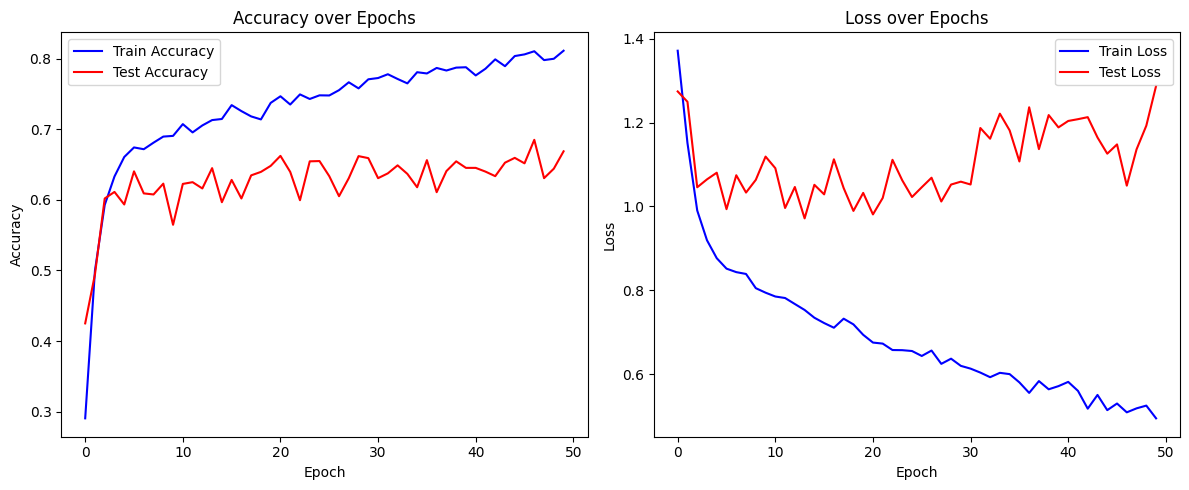

In [23]:
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(trainacc, label='Train Accuracy', c='b')
plt.plot(testacc, label='Test Accuracy', c='r')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(trainloss, label='Train Loss', c='b')
plt.plot(testloss, label='Test Loss', c='r')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model0(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


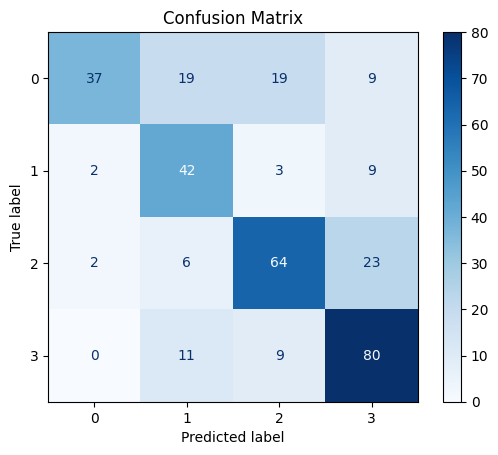

In [26]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')  # Optional: nicer color
plt.title("Confusion Matrix")
plt.show()
